<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short introduction to the Outlier package

In [1]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence

In [4]:
%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

Populating the interactive namespace from numpy and matplotlib


In [5]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/Keras')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
VERSION = tfds.core.Version('0.1.0')
dataset, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [0]:
## Implementing a simple resnet model
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y
  
def augmentation(x, y):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = x + 0.02*tf.random.normal(shape=(128,128,1))
  return x, y

In [0]:
DATASET_SIZE = 20000
BATCH_SIZE = 32

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = dataset.map(redefine).map(downsample)

train_dataset= full_dataset.take(train_size).repeat().map(augmentation).shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).take(test_size).batch(BATCH_SIZE)

### Let's define the neural network

In [0]:
inputs = tf.keras.Input(shape=(128, 128, 1))
resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                    weights=None,
                                                    input_shape=[128,128,1],
                                                    pooling='avg')
net = resnet(inputs)
outputs = tf.keras.layers.Dense(2)(net)

In [0]:
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 2048)              23558528  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,562,626
Trainable params: 23,517,186
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse')   

In [13]:
history = model.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE,
                    validation_data=test_dataset, verbose=1, 
                    steps_per_epoch=int(0.8*20000/BATCH_SIZE)-1,
                    validation_steps=2)

Epoch 1/50
499/499 [==============================] - 206s 413ms/step - loss: 0.1547 - val_loss: 0.0185
Epoch 2/50
499/499 [==============================] - 176s 353ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 3/50
499/499 [==============================] - 177s 354ms/step - loss: 0.0172 - val_loss: 0.0278
Epoch 4/50
499/499 [==============================] - 184s 368ms/step - loss: 0.0164 - val_loss: 0.0467
Epoch 5/50
499/499 [==============================] - 168s 336ms/step - loss: 0.0175 - val_loss: 0.0201
Epoch 6/50
499/499 [==============================] - 148s 296ms/step - loss: 0.0167 - val_loss: 0.0265
Epoch 7/50
499/499 [==============================] - 184s 370ms/step - loss: 0.0174 - val_loss: 0.0130
Epoch 8/50
499/499 [==============================] - 158s 316ms/step - loss: 0.0157 - val_loss: 0.0201
Epoch 9/50
499/499 [==============================] - 169s 338ms/step - loss: 0.0160 - val_loss: 0.0360
Epoch 10/50
499/499 [==============================] - 178s 357m

In [15]:
truth = next(train_dataset.as_numpy_iterator()) 
print (truth[0].shape, truth[1].shape)

(32, 128, 128, 1) (32, 2)


In [0]:
predictions = model.predict(x=truth[0])

In [0]:
S8_gen= lambda params: sqrt(params.T[0]/0.3)*params.T[1]

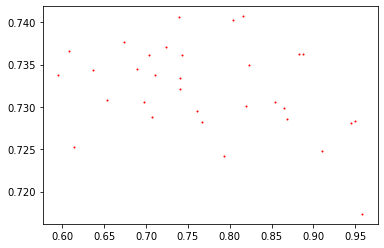

In [17]:
scatter(truth[1][:,1], predictions[:,1],color='r',s=1)

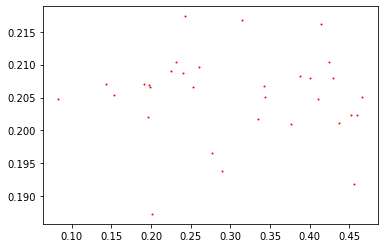

In [18]:
scatter(truth[1][:,0], predictions[:,0],color='r',s=1)

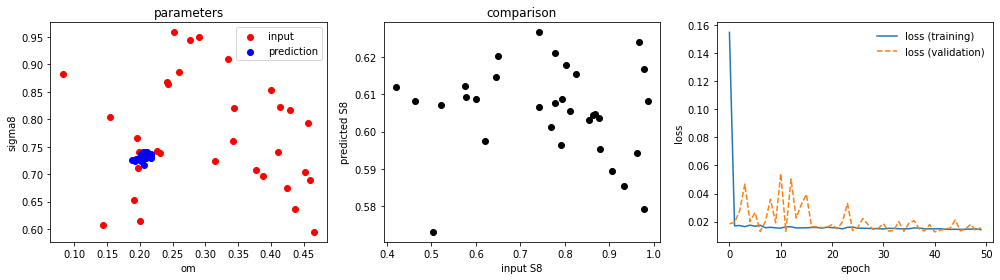

In [41]:
params_pred = predictions
params_input = truth[1]
true_s8=S8_gen(params_input)
pred_s8=S8_gen(np.array(params_pred))
losses_train=history.history['loss']
losses_val=history.history['val_loss']
epocharr=history.epoch

figure(figsize=(14,4))
subplot(1,3,1)
scatter(params_input.T[0], params_input.T[1],color='r', label='input')
scatter(params_pred.T[0], params_pred.T[1],color='b', label='prediction')
title('parameters')
xlabel('om')
ylabel('sigma8')
legend(fontsize=10, frameon=1)
subplot(1,3,2)
scatter(true_s8, pred_s8, color='k')
xlabel('input S8')
ylabel('predicted S8')
#ylim(0,1)
title('comparison')
subplot(1,3,3)
plot(epocharr, losses_train,'-',label='loss (training)')
plot(epocharr, losses_val, '--',label='loss (validation)')
legend(fontsize=10, frameon=0)
xlabel('epoch')
ylabel('loss')
# title('N_epoch={} stepsize={}'.format(epoch, step_size))
plt.tight_layout()